1. INSTALLING DEPENDENCIES

In [ ]:
!pip install 'shimmy>=2.0'
import gym
from gym import spaces
import numpy as np
!pip install stable-baselines3[extra]
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt
import heapq
!pip install torch
import torch
from torch.optim.lr_scheduler import LambdaLR
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CheckpointCallback
import logging
from logging.handlers import RotatingFileHandler

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


2. CREATING ENVIRONMENT

In [ ]:


# class twoDEnv(gym.Env):
#     def __init__(self, grid_size=20.0, with_obstacles=True):
#         # Scalable grid configuration
#         self.grid_size = float(grid_size)
#         self.min = 0.0
#         self.max = float(grid_size)
#         self.scale = 1.0  # Normalized scale

#         # Action and observation spaces
#         self.action_space = gym.spaces.Discrete(6)
#         self.observation_space = gym.spaces.Box(
#             low=np.array([0.0, 0.0], dtype=np.float32),
#             high=np.array([float(grid_size), float(grid_size)], dtype=np.float32),
#             dtype=np.float32
#         )

#         # Drone parameters with more adaptive scaling
#         self.drone_mass = 65.0
#         self.payload = 30.0
#         self.max_velocity = np.array([float(grid_size) * 0.01, float(grid_size) * 0.01])
#         self.max_speed = np.linalg.norm(self.max_velocity)

#         # Environment setup
#         self.with_obstacles = with_obstacles
#         self.dt = 0.1
#         self.fluid_density = 1.0
#         self.drag_coeff = 1.1

#         # State variables
#         self.drone_pos = np.array([0.0, 0.0])
#         self.drone_vel = np.array([0.0, 0.0])
#         self.drone_acc = np.array([0.0, 0.0])

#         # Target and obstacles
#         self.target = np.array([float(grid_size), float(grid_size)])
#         self.obstacles = []

#         # Performance tracking
#         self.cumulative_reward = []
#         self.reward_history = []

#         # Initialize obstacles if needed
#         if self.with_obstacles:
#             self._generate_smart_obstacles()

#     def _generate_smart_obstacles(self):
#         """Generate obstacles that scale with grid size"""
#         num_obstacles = max(2, int(self.grid_size / 200.0))  # Adaptive number of obstacles
#         self.obstacles = []

#         for _ in range(num_obstacles):
#             # Randomly place obstacles, avoiding start and end regions
#             low = np.random.uniform(self.grid_size * 0.1, self.grid_size * 0.9, 2)
#             size = np.random.uniform(self.grid_size * 0.20, self.grid_size * 0.25, 2)
#             high = low + size

#             obstacle = gym.spaces.Box(
#                 low=low,
#                 high=high,
#                 dtype=np.float32
#             )
#             self.obstacles.append(obstacle)

#     def _adaptive_reward_function(self, dist_to_target, dist_to_obstacles, power):
#         """More adaptive reward calculation"""
#         # Normalize distances
#         norm_target_dist = dist_to_target / self.grid_size
#         norm_obstacle_dist = dist_to_obstacles / self.grid_size

#         # Target proximity reward (decreases exponentially with distance)
#         target_reward = np.exp(-norm_target_dist) * 100.0 * 1.5
#         print("Distance to obstacles:",dist_to_obstacles)
#         print("Distance to target:",dist_to_target)

#         # Obstacle avoidance reward
#         obstacle_penalty = -50.0 * np.exp(-norm_obstacle_dist) if self.with_obstacles else 0.0

#         # Energy efficiency penalty
#         energy_penalty = power * 0.1

#         # Combine rewards
#         total_reward = target_reward + obstacle_penalty - energy_penalty

#         return total_reward
#     # def _adaptive_reward_function(self, dist_to_target, dist_to_obstacles, power):
#     #     """More adaptive reward calculation with incorporated features from get_reward_ver2"""
#     #     # Normalize distances
#     #     norm_target_dist = dist_to_target / self.grid_size
#     #     norm_obstacle_dist = dist_to_obstacles / self.grid_size
#     #     # print(dist_to_target)
#     #     # Target proximity reward (logarithmic scaling)
#     #     target_reward = 10 / (np.log(dist_to_target + 1.1))

#     #     # Obstacle avoidance penalties
#     #     padding = 2.5
#     #     inner_penalty = -20  # Reward at the boundary of obstacle and padded region
#     #     outer_penalty = 0    # Reward at the boundary of padded and outer region

#     #     # Loop over all obstacles
#     #     # obstacles = [
#     #     #     # self.obstacle1,
#     #     #     # self.obstacle2,
#     #     #     # Add other obstacles as needed
#     #     # ]

#     #     reward = target_reward
#     #     obstacle_penalty = 0  # Initialize obstacle_penalty
#     #     for obstacle in self.obstacles:
#     #         # Define the exact obstacle boundaries
#     #         obstacle_low = obstacle.low
#     #         obstacle_high = obstacle.high

#     #         # Define the padded obstacle boundaries
#     #         padded_low = obstacle_low - padding
#     #         padded_high = obstacle_high + padding

#     #         # Check if the drone is inside the exact obstacle boundary
#     #         if (obstacle_low <= self.drone_pos).all() and (self.drone_pos <= obstacle_high).all():
#     #             reward += inner_penalty  # Collision penalty
#     #             obstacle_penalty += inner_penalty

#     #         # Check if the drone is inside the padded region
#     #         if (padded_low <= self.drone_pos).all() and (self.drone_pos <= padded_high).all():
#     #             # Calculate distance from the padded region's outer edge
#     #             distance_from_outer = np.min([np.abs(self.drone_pos - padded_low), np.abs(self.drone_pos - padded_high)])
#     #             # Interpolate reward between inner_penalty and outer_penalty
#     #             reward += outer_penalty + (inner_penalty - outer_penalty) * (distance_from_outer / padding)
#     #             obstacle_penalty += outer_penalty + (inner_penalty - outer_penalty) * (distance_from_outer / padding)
#     #             break  # No need to check other obstacles

#     #     # Out-of-bounds penalty
#     #     if not self.is_valid_state(self.drone_pos):
#     #         return -10  # Scaled down from -10000

#     #     # Goal reward (scaled for smoother learning)
#     #     if np.array_equal(self.drone_pos, self.target) or (
#     #         np.abs(self.drone_pos[0] - self.target[0]) <= 3 and np.abs(self.drone_pos[1] - self.target[1]) <= 3
#     #     ):
#     #         return 10  # Scaled down from +1000

#     #     # Energy efficiency penalty
#     #     energy_penalty = power * 0.1

#     #     # Combine rewards
#     #     total_reward = target_reward + obstacle_penalty - energy_penalty
#     #     return total_reward

#     def step(self, action):
#         # Update acceleration based on action
#         action_map = {
#             0: np.array([1, 0.0]),    # Right
#             1: np.array([-1, 0.0]),   # Left
#             2: np.array([0.0, 1]),    # Up
#             3: np.array([0.0, -1]),   # Down
#             4: np.array([1, 1]),    # Diagonal up-right
#             5: np.array([-1, -1])   # Diagonal down-left
#         }
#         action = action.item() if isinstance(action, np.ndarray) else action
#         self.drone_acc = action_map[action]

#         # Update velocity with adaptive drag
#         speed = np.linalg.norm(self.drone_vel)
#         drag_factor = 0.5 * self.fluid_density * speed**2 * self.drag_coeff

#         # More sophisticated velocity update
#         self.drone_vel += self.drone_acc * self.dt
#         self.drone_vel -= drag_factor * self.drone_vel * self.dt
#         self.drone_vel = np.clip(self.drone_vel, -self.max_velocity, self.max_velocity)

#         # Update position
#         self.drone_pos += self.drone_vel * self.dt
#         self.drone_pos = np.clip(self.drone_pos, 0.0, self.grid_size)
#         # print(self.drone_pos)
#         # print(self.target)
#         # Calculate distances and power
#         dist_to_target = np.linalg.norm(self.drone_pos - self.target)
#         # print(dist_to_target)
#         # Obstacle distance calculation
#         dist_to_obstacles = self._calculate_obstacle_distance()

#         # Power calculation
#         power = self._calculate_power()

#         # Adaptive reward
#         reward = self._adaptive_reward_function(dist_to_target, dist_to_obstacles, power)

#         # Check termination conditions
#         done = np.linalg.norm(self.drone_pos - self.target) < 4

#         if done:
#             print("Episode done")
#             reward += 1000.0 if np.linalg.norm(self.drone_pos - self.target) < self.grid_size * 0.01 else -1000.0
#             self.cumulative_reward.append(reward)
#             reward = 0
#         return self.drone_pos, reward, done, {}

#     def _calculate_power(self):
#         """Calculate instantaneous power with adaptive scaling"""
#         acceleration_magnitude = np.linalg.norm(self.drone_acc)
#         total_mass = self.drone_mass + self.payload
#         power = total_mass * acceleration_magnitude * np.linalg.norm(self.drone_vel)
#         return power

#     def _calculate_obstacle_distance(self):
#         """Calculate minimum distance to obstacles"""
#         if not self.with_obstacles:
#             return float(self.grid_size)  # Maximum possible distance

#         distances = []
#         for obstacle in self.obstacles:
#             # Calculate distance to obstacle with padding
#             dist = self._distance_to_box(self.drone_pos, obstacle)
#             distances.append(dist)

#         return min(distances) if distances else float(self.grid_size)

#     def _distance_to_box(self, point, box):
#         """Calculate distance from a point to a box"""
#         dx = max(box.low[0] - point[0], 0.0, point[0] - box.high[0])
#         dy = max(box.low[1] - point[1], 0.0, point[1] - box.high[1])
#         return np.sqrt(dx**2 + dy**2)

#     def _check_obstacle_collision(self):
#         """Check if drone has collided with any obstacles"""
#         for obstacle in self.obstacles:
#             if (
#                 obstacle.low[0] <= self.drone_pos[0] <= obstacle.high[0] and
#                 obstacle.low[1] <= self.drone_pos[1] <= obstacle.high[1]
#             ):
#                 return True
#         return False

#     def reset(self):
#         """Reset the environment to initial state"""
#         self.drone_pos = np.array([0.0, 0.0])
#         self.drone_vel = np.array([0.0, 0.0])
#         self.drone_acc = np.array([0.0, 0.0])
#         return self.drone_pos



class twoDEnv(gym.Env):

    def __init__(self):
        self.min  = 0
        self.max = 10
        self.scale = 2
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(low=np.array([self.min, self.min]), high=np.array([self.max*self.scale, self.max*self.scale]), dtype=np.float32)

        # Drone position and velocity
        self.drone_pos = np.array([0.0, 0.0])
        self.drone_vel = np.array([0.0, 0.0])
        self.max_velocity = np.array([20.0, 20.0])
        self.max_speed = 20.0

        #origin, or the starting place of the drone has been considered a single point
        self.origin = np.array([0.0, 0.0])
        self.extreme = np.array([self.max*self.scale, self.max*self.scale])
        self.drone_acc = np.array([0.0, 0.0])

        # mass in kg(with batteries)
        self.drone_mass = 65

        #  mass of payload
        self.payload = 30

        #dimensions of drone, with arms and propellors folded
        # 760x1027 mm = W x H
        self.L = 1115* (1e-3)
        self.W = 760* (1e-3)
        self.H = 1027* (1e-3)
        self.cross_section_area = self.W*self.H

        #A buffer for the target has to be set since, practically, the drone can not arrive exactly at a single point. By setting a buffer, training time also reduces significantly.
        self.target = np.array([self.max*self.scale, self.max*self.scale])
        self.num_obstacles = 2

        self.obstacle1 = spaces.Box(low = np.array([2.0*self.scale*0.9, 2.0*self.scale*0.9]), high=np.array([4.0*self.scale*0.9, 4.0*self.scale*0.9]), dtype = np.float32)
        self.obstacle2 = spaces.Box(low = np.array([8.00*self.scale*0.9,2.00*self.scale*0.9]),high = np.array([9.0*self.scale*0.9,4.0*self.scale*0.9]),dtype = np.float32)
        # self.obstacle3 = spaces.Box(low = np.array([2.0*self.scale,2.00*self.scale]),high = np.array([3.50*self.scale,3.50*self.scale]),dtype = np.float32)
        # self.obstacle4 = spaces.Box(low = np.array([4.0*self.scale,1.0*self.scale]),high = np.array([5.50*self.scale,2.50*self.scale]),dtype = np.float32)
        self.obstacles = [
            self.obstacle1,
            self.obstacle2,
            # Add other obstacles as needed
        ]
        self.dt = 0.1
        self.cumulative_reward = []
        self.reward=0
        self.fluid_density = 1.0  # kg/m^3, for air at sea level
        self.drag_coeff = 1.1  # Assumed value for a spherical object

        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG)

        # Console handler
        console_handler = logging.StreamHandler()
        console_handler.setLevel(logging.INFO)

        # File handler with rotation
        file_handler = RotatingFileHandler(
            'drone_environment.log',
            maxBytes=1048576,  # 1 MB
            backupCount=3
        )
        file_handler.setLevel(logging.DEBUG)

        # Formatters
        console_format = logging.Formatter('%(levelname)s - %(message)s')
        file_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

        console_handler.setFormatter(console_format)
        file_handler.setFormatter(file_format)

        # Add handlers
        self.logger.addHandler(console_handler)
        self.logger.addHandler(file_handler)

        # Initialize tracking variables
        self.episode_count = 0

# #--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def is_valid_state(self, state):
        x, y = state
        padding = 2.5  # 2 meters of padding

        # Check if the UAV is out of bounds
        if x < self.min or x > self.max * self.scale or y < self.min or y > self.max * self.scale:
            return False

        return True
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    def distance_from_target(self):
        dist = np.linalg.norm(self.drone_pos - self.target)
        return dist
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    def choose_action(self, direction):
          """Selects the action based on direction towards the target point on the path."""
          if direction[0] > 0:
              return 0  # Move right
          elif direction[0] < 0:
              return 1  # Move left
          elif direction[1] > 0:
              return 3  # Move up
          elif direction[1] < 0:
              return 4  # Move down
          return 2  # No movement
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def distance_from_obstacle(self):
          padding = 2.5  # 1.5 meters of padding
          distances = []

          # obstacles = [
          #     self.obstacle1,
          #     self.obstacle2,
          #     # Add other obstacles as needed
          # ]

          for obstacle in self.obstacles:
              padded_low = obstacle.low - padding
              padded_high = obstacle.high + padding

              x, y = self.drone_pos

              # Calculate the distance from the UAV to the closest side of the obstacle with padding
              dist_x = max(padded_low[0] - x, 0, x - padded_high[0])
              dist_y = max(padded_low[1] - y, 0, y - padded_high[1])

              # Euclidean distance to the nearest padded boundary
              dist_to_boundary = np.sqrt(dist_x**2 + dist_y**2)
              distances.append(dist_to_boundary)

          return np.mean(distances) if distances else 0.0
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def update_velocity(self):
        speed = np.linalg.norm(self.drone_vel)
        drag_force_magnitude = 0.5 * (self.fluid_density) * (speed**2) * (self.drag_coeff) * (self.cross_section_area)
        drag_force = (drag_force_magnitude / speed) * self.drone_vel if speed != 0 else np.array([0.0, 0.0])

        self.drone_vel += (self.drone_acc*(self.drone_mass+self.payload) - drag_force) * self.dt
        self.drone_vel = np.clip(self.drone_vel, -self.max_velocity, self.max_velocity)
        return self.drone_vel
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def update_position(self, velocity):
        self.drone_pos += velocity * self.dt
        self.drone_pos = np.clip(self.drone_pos, self.origin,self.extreme)
        return self.drone_pos
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def instantaneous_power(self, velocity, acceleration,motor_eff,prop_eff):
        force = (self.drone_mass+self.payload) * acceleration
        power = np.dot(velocity, force) / (self.drone_mass+self.payload)
        input_total_power = power/np.dot(motor_eff,prop_eff)
        return power
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def get_reward(self,power,dist_target,dist_obs):
        proximity_penalty = 1500 / (dist_obs**2 + 1e-2)  # Penalty increases as the drone gets closer to obstacles
        target_reward = 400 / (dist_target + 1e-2)
        padding = 2.5

        """
        If UAV is out of bounds, then assign it a huge negative reward
        """

        if not self.is_valid_state(self.drone_pos):
            return -10000

        if np.array_equal(self.drone_pos, self.target) or (np.abs(self.drone_pos[0] - self.target[0]) <= 3 and np.abs(self.drone_pos[1] - self.target[1]) <= 3):
            return 1000

        # if uav is in padded area, assign negative reward
        # obstacles = [
        #     self.obstacle1,
        #     self.obstacle2,
        #     # Add other obstacles as needed
        # ]
        for obstacle in self.obstacles:
            padded_low = obstacle.low - padding
            padded_high = obstacle.high + padding

            # Check if the UAV is within the padded boundaries of any obstacle
            if (padded_low <= self.drone_pos).all() and (self.drone_pos <= padded_high).all():
                return target_reward - 1.5*proximity_penalty - 0.5*power

        # Penalty based on proximity to obstacles and distance to the target

               # Reward for moving closer to the target
        return target_reward - proximity_penalty - power

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def get_reward_ver2(self, power, dist_target, dist_obs):
    # Logarithmic scaling for proximity penalties
        # proximity_penalty = 10 / (np.log(dist_obs + 1.1))
        target_reward = 10 / (np.log(dist_target + 1.1))
        padding = 2.5

        # Out-of-bounds penalty
        if not self.is_valid_state(self.drone_pos):
            return -10  # Scaled down from -10000

        # Goal reward (scaled for smoother learning)
        if np.array_equal(self.drone_pos, self.target) or (
            np.abs(self.drone_pos[0] - self.target[0]) <= 3 and np.abs(self.drone_pos[1] - self.target[1]) <= 3
        ):
            return 10  # Scaled down from +1000

        inner_penalty = -20  # Reward at the boundary of obstacle and padded region
        outer_penalty = 0    # Reward at the boundary of padded and outer region
        power_penalty_factor = 0.1  # Penalty factor for power consumption

        # Loop over all obstacles
        # obstacles = [
        #     # self.obstacle1,
        #     # self.obstacle2,
        #     # Add other obstacles as needed
        # ]

        reward = target_reward

        for obstacle in self.obstacles:
            # Define the exact obstacle boundaries
            obstacle_low = obstacle.low
            obstacle_high = obstacle.high

            # Define the padded obstacle boundaries
            padded_low = obstacle_low - padding
            padded_high = obstacle_high + padding

            # Check if the drone is inside the exact obstacle boundary
            if (obstacle_low <= self.drone_pos).all() and (self.drone_pos <= obstacle_high).all():
                reward += inner_penalty  # Collision penalty

            # Check if the drone is inside the padded region
            if (padded_low <= self.drone_pos).all() and (self.drone_pos <= padded_high).all():
                # Calculate distance from the padded region's outer edge
                distance_from_outer = np.min(
                    [np.abs(self.drone_pos - padded_low), np.abs(self.drone_pos - padded_high)]
                )

                # Interpolate reward between inner_penalty and outer_penalty
                reward += outer_penalty + (inner_penalty - outer_penalty) * (distance_from_outer / padding)
                break  # No need to check other obstacles

        # Apply power penalty
        reward -= power_penalty_factor * power

        # Return the final reward
        return reward

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


    def step(self, action):
        # self.episode_count += 1
        # done = False

        # # Log the action being taken
        # self.logger.info(f"Episode {self.episode_count}: Taking action {action}")

        # # Action mapping with logging
        # action_map = {
        #     0: (1.0, 0),    # Positive x acceleration
        #     1: (-1.0, 0),   # Negative x acceleration
        #     2: (0, 0),      # No x acceleration
        #     3: (0, 1.0),    # Positive y acceleration
        #     4: (0, -1.0),   # Negative y acceleration
        #     5: (0, 0)       # No y acceleration
        # }

        # try:
        #     # Safely apply acceleration
        #     dx, dy = action_map.get(action, (0, 0))
        #     self.drone_acc[0] += dx
        #     self.drone_acc[1] += dy

        #     # Log acceleration details
        #     self.logger.debug(f"Updated drone acceleration: {self.drone_acc}")

        #     # Prevent NaN values with robust checking
        #     self.drone_acc = np.nan_to_num(self.drone_acc, nan=0.0)

        #     # Physics and movement calculations
        #     motor_eff = 0.8
        #     prop_eff = 0.9

        #     # Log physics parameters
        #     self.logger.debug(f"Motor efficiency: {motor_eff}, Propeller efficiency: {prop_eff}")

        #     # Power and movement calculations
        #     power = self.instantaneous_power(self.drone_vel, self.drone_acc, motor_eff, prop_eff)
        #     velocity = self.update_velocity()
        #     self.drone_pos = self.update_position(velocity)

        #     # Log key calculations
        #     self.logger.debug(f"Calculated power: {power}")
        #     self.logger.debug(f"Updated velocity: {velocity}")
        #     self.logger.debug(f"Updated position: {self.drone_pos}")

        #     # Safety checks with logging
        #     if not np.all(np.isfinite(self.drone_pos)) or not np.all(np.isfinite(self.drone_vel)):
        #         self.logger.warning("Invalid position or velocity detected")
        #         raise ValueError("Invalid position or velocity")

        #     # Distance calculations
        #     dist_target = self.distance_from_target()
        #     dist_obstacle = self.distance_from_obstacle()

        #     # Log distance information
        #     self.logger.debug(f"Distance to target: {dist_target}")
        #     self.logger.debug(f"Distance to obstacle: {dist_obstacle}")

        #     # Pathfinding optimization
        #     # optimal_path = self.astar_path(self.drone_pos, self.target)
        #     # if optimal_path:
        #     #     next_pos = np.array(optimal_path[0])
        #     #     move_direction = next_pos - self.drone_pos
        #     #     action = self.choose_action(move_direction)
        #     #     self.logger.info(f"Optimal path found. Next position: {next_pos}")

        #     # Reward calculation
        #     reward = self.get_reward(power, dist_target, dist_obstacle)
        #     self.reward += reward / 10

        #     # Log reward details
        #     self.logger.debug(f"Calculated reward: {reward}")
        #     self.logger.debug(f"Cumulative reward: {self.reward}")

        #     # Check for episode completion
        #     done = (np.abs(self.drone_pos[0] - self.target[0]) <= 3 and
        #             np.abs(self.drone_pos[1] - self.target[1]) <= 3)

        #     if done:
        #         self.logger.info(f"Episode {self.episode_count} completed")
        #         self.cumulative_reward.append(self.reward)
        #         self.reward = 0

        #     return self.drone_pos, reward, done, {}

        # except Exception as e:
        #     # Comprehensive error logging
        #     self.logger.error(f"Error in step function during episode {self.episode_count}", exc_info=True)

        #     # Provide a safe fallback
        #     return self.drone_pos, -1, True, {'error': str(e)}
        # Update the drone's acceleration based on the action
        done = False
        if action == 0:
            self.drone_acc[0] += 1.0
        elif action == 1:
            self.drone_acc[0] -= 1.0
        elif action == 2:
            self.drone_acc[0] += 0
        elif action == 3:
            self.drone_acc[1] += 1.0
        elif action == 4:
            self.drone_acc[1] -= 1.0
        elif action == 5:
            self.drone_acc[1] += 0

        # Ensure that the acceleration does not produce NaN values
        assert not np.isnan(self.drone_acc).any(), "NaN in acceleration"
        motor_eff = 0.8
        prop_eff = 0.9
        power = self.instantaneous_power(self.drone_vel, self.drone_acc,motor_eff,prop_eff)
        velocity = self.update_velocity()
        self.drone_pos = self.update_position(velocity)
        dist_target = self.distance_from_target()
        dist_obstacle = self.distance_from_obstacle()

        # Update the drone's position and velocity

        optimal_path = self.astar_path(self.drone_pos, self.target)
        if optimal_path:
            # Calculate optimal next move based on path
            next_pos = np.array(optimal_path[0])  # First step in the path
            move_direction = next_pos - self.drone_pos
            action = self.choose_action(move_direction)
        # Ensure that position and velocity do not produce NaN values
        assert not np.isnan(self.drone_pos).any(), "NaN in position"
        assert not np.isnan(self.drone_vel).any(), "NaN in velocity"

        count = 0
        reward = self.get_reward(power,dist_target,dist_obstacle)
        self.reward+=reward/10

        if np.abs(self.drone_pos[0] - self.target[0]) <= 3 and np.abs(self.drone_pos[1] - self.target[1]) <= 3:
            done = True

        if done:
          # print("Episode done")
          self.cumulative_reward.append(self.reward)
          self.reward=0


        return self.drone_pos, reward, done, {}
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def reset(self):
        self.drone_pos = np.array([0.0, 0.0])
        self.drone_vel = np.array([0.0, 0.0])
        self.drone_acc = np.array([0.0, 0.0])
        self.reward = 0
        return self.drone_pos

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    def astar_path(self, start, goal):

        grid_size = 1.0
        start_grid = tuple(np.round(start / grid_size).astype(int))
        goal_grid = tuple(np.round(goal / grid_size).astype(int))


        obstacles = []
        padding = 2.5
        for obstacle in [self.obstacle1, self.obstacle2]:
            low = tuple(np.round((obstacle.low - padding) / grid_size).astype(int))
            high = tuple(np.round((obstacle.high + padding) / grid_size).astype(int))
            for x in range(low[0], high[0] + 1):
                for y in range(low[1], high[1] + 1):
                    obstacles.append((x, y))

        open_set = []
        heapq.heappush(open_set, (0, start_grid))
        came_from = {}
        g_score = {start_grid: 0}
        f_score = {start_grid: np.linalg.norm(np.array(start_grid) - np.array(goal_grid))}

        while open_set:
            _, current = heapq.heappop(open_set)
            if current == goal_grid:
                # Reconstruct the path
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.reverse()
                return path

            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Neighbor offsets
                neighbor = (current[0] + dx, current[1] + dy)
                if neighbor in obstacles or neighbor[0] < 0 or neighbor[1] < 0:
                    continue  # Skip obstacles and out-of-bounds cells

                tentative_g_score = g_score[current] + np.linalg.norm(np.array(neighbor) - np.array(current))
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + np.linalg.norm(np.array(neighbor) - np.array(goal_grid))
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

        return None



###3. TRAINING THE MODEL

In [ ]:
from inspect import modulesbyfile
from gym.envs.registration import register
from stable_baselines3.common.type_aliases import Schedule
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
register(
    id='twoDEnv-v0',
    entry_point='__main__:twoDEnv',
)

# Create the environment
env = gym.make('twoDEnv-v0')
env_vec = make_vec_env(lambda: env, n_envs=1)

model = PPO(
    'MlpPolicy',
    env,
    learning_rate=3*(1e-4),  # Learning rate decay
    n_steps=1024,              # Keep large batch size
    batch_size=128,            # Increase batch size
    n_epochs=10,               # Slightly more epochs
    gamma=0.99,                # Keep standard discount factor
    gae_lambda=0.95,           # Keep standard GAE
    ent_coef=0.02,             # Slightly increase exploration
    vf_coef=0.5,               # Keep value function coefficient
    max_grad_norm=0.5,         # Keep gradient clipping
    verbose=1
)


model.learn(total_timesteps=20000*2)
# model.learn(total_timesteps=10000)
print(env.cumulative_reward)





/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment twoDEnv-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/pyth

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Streaming output truncated to the last 5000 lines.
DEBUG:twoDEnv:Updated velocity: [-20. -20.]
DEBUG:twoDEnv:Updated position: [0. 0.]
DEBUG:twoDEnv:Distance to target: 28.284271247461902
DEBUG:twoDEnv:Distance to obstacle: 6.753183295126971
DEBUG:twoDEnv:Calculated reward: -338.74643301455546
DEBUG:twoDEnv:Cumulative reward: -8128.566414146683
INFO - Episode 571: Taking action 2
INFO:twoDEnv:Episode 571: Taking action 2
DEBUG:twoDEnv:Updated drone acceleration: [-10.  -6.]
DEBUG:twoDEnv:Motor efficiency: 0.8, Propeller efficiency: 0.9
DEBUG:twoDEnv:Calculated power: 320.0
DEBUG:twoDEnv:Updated velocity: [-20. -20.]
DEBUG:twoDEnv:Updated position: [0. 0.]
DEBUG:twoDEnv:Distance to target: 28.284271247461902
DEBUG:twoDEnv:Distance to obstacle: 6.753183295126971
DEBUG:twoDEnv:Calculated reward: -338.74643301455546
DEBUG:twoDEnv:Cumulative reward: -8162.441057448139
INFO - Episode 572: Taking action 5
INFO:twoDEnv:Episode 572: Taking action 5
DEBUG:twoDEnv:Updated drone acceleration: [-10

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 49.5      |
|    ep_rew_mean     | -5.91e+03 |
| time/              |           |
|    fps             | 28        |
|    iterations      | 1         |
|    time_elapsed    | 35        |
|    total_timesteps | 1024      |
----------------------------------


Streaming output truncated to the last 5000 lines.
DEBUG:twoDEnv:Updated velocity: [-20. -20.]
DEBUG:twoDEnv:Updated position: [0. 0.]
DEBUG:twoDEnv:Distance to target: 28.284271247461902
DEBUG:twoDEnv:Distance to obstacle: 6.753183295126971
DEBUG:twoDEnv:Calculated reward: -318.74643301455546
DEBUG:twoDEnv:Cumulative reward: -61813.946886110694
INFO - Episode 1595: Taking action 3
INFO:twoDEnv:Episode 1595: Taking action 3
DEBUG:twoDEnv:Updated drone acceleration: [-12.  -2.]
DEBUG:twoDEnv:Motor efficiency: 0.8, Propeller efficiency: 0.9
DEBUG:twoDEnv:Calculated power: 280.0
DEBUG:twoDEnv:Updated velocity: [-20.         -14.71591667]
DEBUG:twoDEnv:Updated position: [0. 0.]
DEBUG:twoDEnv:Distance to target: 28.284271247461902
DEBUG:twoDEnv:Distance to obstacle: 6.753183295126971
DEBUG:twoDEnv:Calculated reward: -298.74643301455546
DEBUG:twoDEnv:Cumulative reward: -61843.82152941215
INFO - Episode 1596: Taking action 4
INFO:twoDEnv:Episode 1596: Taking action 4
DEBUG:twoDEnv:Updated dro

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.5          |
|    ep_rew_mean          | -5.91e+03     |
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 2             |
|    time_elapsed         | 76            |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 3.3027492e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.79         |
|    explained_variance   | 1.65e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.06e+07      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000541     |
|    value_loss           | 4.16e+07      |
-------------------------------------------


Streaming output truncated to the last 5000 lines.
DEBUG:twoDEnv:Distance to target: 20.0
DEBUG:twoDEnv:Distance to obstacle: 6.0307547510826325
DEBUG:twoDEnv:Calculated reward: -301.2414376017389
DEBUG:twoDEnv:Cumulative reward: -102531.21597454265
INFO - Episode 2619: Taking action 1
INFO:twoDEnv:Episode 2619: Taking action 1
DEBUG:twoDEnv:Updated drone acceleration: [ 7. -6.]
DEBUG:twoDEnv:Motor efficiency: 0.8, Propeller efficiency: 0.9
DEBUG:twoDEnv:Calculated power: 260.0
DEBUG:twoDEnv:Updated velocity: [ 20. -20.]
DEBUG:twoDEnv:Updated position: [20.  0.]
DEBUG:twoDEnv:Distance to target: 20.0
DEBUG:twoDEnv:Distance to obstacle: 6.0307547510826325
DEBUG:twoDEnv:Calculated reward: -281.2414376017389
DEBUG:twoDEnv:Cumulative reward: -102559.34011830282
INFO - Episode 2620: Taking action 1
INFO:twoDEnv:Episode 2620: Taking action 1
DEBUG:twoDEnv:Updated drone acceleration: [ 6. -6.]
DEBUG:twoDEnv:Motor efficiency: 0.8, Propeller efficiency: 0.9
DEBUG:twoDEnv:Calculated power: 240.0

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 609          |
|    ep_rew_mean          | -2.43e+05    |
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 3            |
|    time_elapsed         | 116          |
|    total_timesteps      | 3072         |
| train/                  |              |
|    approx_kl            | 9.600131e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.79        |
|    explained_variance   | -4.67e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.85e+07     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.000245    |
|    value_loss           | 7.37e+07     |
------------------------------------------


INFO - Episode 3073: Taking action 4
INFO:twoDEnv:Episode 3073: Taking action 4
DEBUG:twoDEnv:Updated drone acceleration: [-2.  1.]
DEBUG:twoDEnv:Motor efficiency: 0.8, Propeller efficiency: 0.9
DEBUG:twoDEnv:Calculated power: 53.04552124768632
DEBUG:twoDEnv:Updated velocity: [-17.7584595   8.2847011]
DEBUG:twoDEnv:Updated position: [ 0. 20.]
DEBUG:twoDEnv:Distance to target: 20.0
DEBUG:twoDEnv:Distance to obstacle: 13.048529601096561
DEBUG:twoDEnv:Calculated reward: -41.86484063929131
DEBUG:twoDEnv:Cumulative reward: -211.90878921566858
INFO - Episode 3074: Taking action 4
INFO:twoDEnv:Episode 3074: Taking action 4
DEBUG:twoDEnv:Updated drone acceleration: [-2.  0.]
DEBUG:twoDEnv:Motor efficiency: 0.8, Propeller efficiency: 0.9
DEBUG:twoDEnv:Calculated power: 35.51691900883302
DEBUG:twoDEnv:Updated velocity: [-20.          1.3154084]
DEBUG:twoDEnv:Updated position: [ 0. 20.]
DEBUG:twoDEnv:Distance to target: 20.0
DEBUG:twoDEnv:Distance to obstacle: 13.048529601096561
DEBUG:twoDEnv:Cal

9


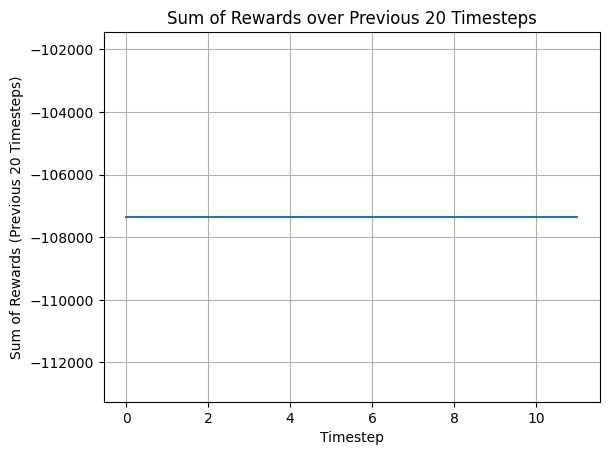

In [ ]:
window_size = 20
moving_sum = np.convolve(env.cumulative_reward, np.ones(window_size), 'valid')
print(len(env.cumulative_reward))
plt.plot(moving_sum)
plt.xlabel('Timestep')
plt.ylabel('Sum of Rewards (Previous 20 Timesteps)')
plt.title('Sum of Rewards over Previous 20 Timesteps')
plt.grid(True)
plt.show()
model.save("ppo_two_env")
model = PPO.load("ppo_two_env")

# cumulative_rewards = [env.cumulative_reward for env in env_vec.envs]

# # Plotting
# plt.figure(figsize=(10, 6))
# for i, rewards in enumerate(cumulative_rewards):
#     plt.plot(rewards, label=f'Env {i+1}')

# plt.xlabel('Timestep')
# plt.ylabel('Cumulative Reward')
# plt.title('Cumulative Rewards across Vectorized Environments')
# plt.legend()
# plt.grid(True)
# plt.show()

# Save and load the model
model.save("ppo_two_env")
model = PPO.load("ppo_two_env")

###**4**. Plotting Function

In [ ]:
def plot_drone_trajectories(positions, env):
    plt.figure(figsize=(10, 8))

    # Plot trajectories
    for episode, episode_positions in enumerate(positions):
        episode_positions = np.array(episode_positions)

        # Plot trajectory
        plt.plot(episode_positions[:, 0], episode_positions[:, 1],
                 label=f'Episode {episode + 1}')

        # Plot start and end points
        plt.plot(episode_positions[0, 0], episode_positions[0, 1],
                 'ro', label='Start' if episode == 0 else "")
        plt.plot(episode_positions[-1, 0], episode_positions[-1, 1],
                 'bs', label='End' if episode == 0 else "")

    # Plot obstacles
    if hasattr(env, 'obstacles'):
        for obstacle in env.obstacles:
            # Use the actual obstacle boundaries
            low = obstacle.low
            high = obstacle.high

            # Draw the obstacle region
            width = high[0] - low[0]
            height = high[1] - low[1]

            # Create a rectangular patch for the obstacle
            rect = plt.Rectangle(
                (low[0], low[1]),  # Bottom-left corner
                width, height,     # Width and height
                color='red',       # Color of the obstacle
                alpha=0.3,         # Transparency
                label='Obstacle'
            )
            plt.gca().add_patch(rect)

        # Optionally, draw padded regions
        padding = 2.5
        for obstacle in env.obstacles:
            low = obstacle.low
            high = obstacle.high

            # Padded region
            padded_low = low - padding
            padded_high = high + padding

            width = padded_high[0] - padded_low[0]
            height = padded_high[1] - padded_low[1]

            padded_rect = plt.Rectangle(
                (padded_low[0], padded_low[1]),  # Bottom-left corner
                width, height,                   # Width and height
                color='blue',                    # Color of padded region
                alpha=0.1,                       # Transparency
                label='Padded Region'
            )
            plt.gca().add_patch(padded_rect)

    # Plot target
    if hasattr(env, 'target'):
        plt.plot(env.target[0], env.target[1], 'g*', markersize=10, label='Target')

    plt.title('Drone Trajectory with no Obstacles and Padded Regions')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling of axes
    plt.tight_layout()
    plt.show()

###**5**. RUNNING OUR MODEL

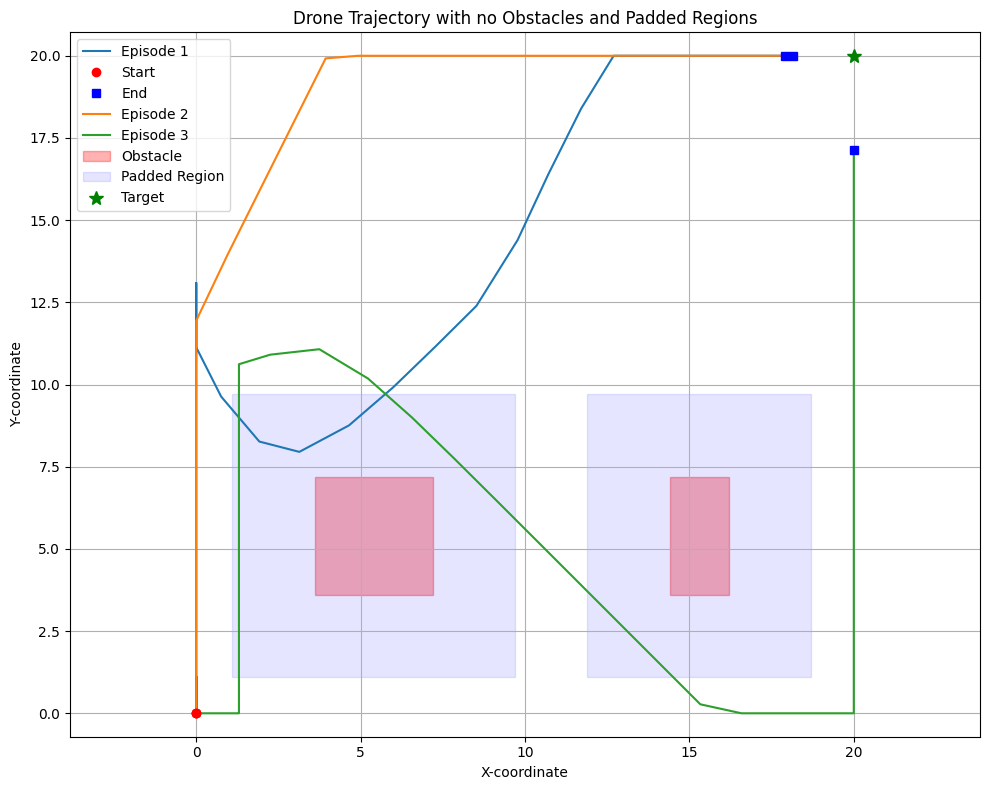

In [ ]:
num_episodes = 3 # Adjust as needed
episode_rewards = []
positions = []
valid_times = []
valid_powers = []
episodes_with_obstacle_entry = 0

for episode in range(num_episodes):
    episode_reward = 0
    done = False
    obs = env.reset()
    episode_positions = []
    entered_obstacle = False
    time_steps = 0
    total_energy = 0

    while not done:
        action, _states = model.predict(obs)
        # print(action)
        obs, reward, done, info = env.step(action)

        episode_reward += reward / 100
        episode_positions.append(env.drone_pos.copy())
        time_steps += 1

        # Energy calculation
        # energy_consumed = env._calculate_power() * env.dt
        # total_energy += energy_consumed

        # Obstacle entry check
        # if env.with_obstacles:
        for obstacle in env.obstacles:
                low = obstacle.low
                high = obstacle.high
                padding = 2.5

                padded_low = low - padding
                padded_high = high + padding

                x_in_obstacle = padded_low[0] <= env.drone_pos[0] <= padded_high[0]
                y_in_obstacle = padded_low[1] <= env.drone_pos[1] <= padded_high[1]

                if x_in_obstacle and y_in_obstacle:
                    entered_obstacle = True
                    # print(f"Obstacle entry detected at {env.drone_pos}")
                    break

    # Tracking episode data
    if not entered_obstacle:
        valid_times.append(time_steps * env.dt)
        valid_powers.append(total_energy / (time_steps * env.dt))
    else:
        episodes_with_obstacle_entry += 1

    episode_rewards.append(episode_reward)
    positions.append(episode_positions)

    # Episode completion message
    # print(f"Episode {episode + 1} {'entered obstacle' if entered_obstacle else 'completed successfully'}.")

# Plot the trajectories
plot_drone_trajectories(positions, env)

# # Optional: Additional analysis
# print(f"Total episodes: {num_episodes}")
# print(f"Episodes with obstacle entry: {episodes_with_obstacle_entry}")
# print(f"Average episode reward: {np.mean(episode_rewards)}")
# if valid_times:
#     print(f"Average completion time: {np.mean(valid_times)} seconds")
#     print(f"Average power consumption: {np.mean(valid_powers)} watts")

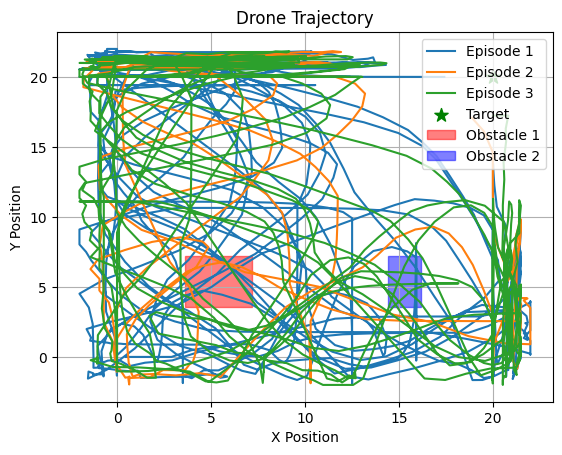

In [ ]:
import matplotlib.pyplot as plt

# Number of episodes
num_episodes = 3
cumulative_reward = []

for episode in range(num_episodes):
    episode_reward = 0
    done = False
    obs = env.reset()

    # Store the trajectory
    trajectory = [obs]

    while not done:
        # Predict action
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

        # Record position
        trajectory.append(obs)

        # Update episode reward
        episode_reward += reward / 100

    # Add episode reward to cumulative reward
    cumulative_reward.append(episode_reward)

    # Plot the trajectory for the current episode
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='', label=f'Episode {episode+1}')

# Plot target and obstacles
plt.scatter(env.target[0], env.target[1], color='green', label='Target', marker='*', s=100)
plt.gca().add_patch(plt.Rectangle(env.obstacle1.low, *(env.obstacle1.high - env.obstacle1.low), color='red', alpha=0.5, label='Obstacle 1'))
plt.gca().add_patch(plt.Rectangle(env.obstacle2.low, *(env.obstacle2.high - env.obstacle2.low), color='blue', alpha=0.5, label='Obstacle 2'))

# Customize the plot
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Drone Trajectory')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
import plotly.graph_objects as go
import numpy as np

# Initialize a Plotly figure
fig = go.Figure()

# Number of episodes
num_episodes = 3
cumulative_reward = []

for episode in range(num_episodes):
    episode_reward = 0
    done = False
    obs = env.reset()

    # Store the trajectory
    trajectory = [obs]

    while not done:
        # Predict action
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

        # Record position
        trajectory.append(obs)

        # Update episode reward
        episode_reward += reward / 100

    # Add episode reward to cumulative reward
    cumulative_reward.append(episode_reward)

    # Convert trajectory to a numpy array
    trajectory = np.array(trajectory)

    # Add the trajectory for the current episode to the Plotly figure
    fig.add_trace(go.Scatter(
        x=trajectory[:, 0],
        y=trajectory[:, 1],
        mode='lines+markers',
        name=f'Episode {episode+1}',
        line=dict(width=2),
        marker=dict(size=6)
    ))

# Add the target position
fig.add_trace(go.Scatter(
    x=[env.target[0]],
    y=[env.target[1]],
    mode='markers',
    marker=dict(size=12, color='green', symbol='star'),
    name='Target'
))

# Add obstacles as rectangles
fig.add_trace(go.Scatter(
    x=[env.obstacle1.low[0], env.obstacle1.high[0], env.obstacle1.high[0], env.obstacle1.low[0], env.obstacle1.low[0]],
    y=[env.obstacle1.low[1], env.obstacle1.low[1], env.obstacle1.high[1], env.obstacle1.high[1], env.obstacle1.low[1]],
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.3)',
    line=dict(color='red'),
    name='Obstacle 1'
))

fig.add_trace(go.Scatter(
    x=[env.obstacle2.low[0], env.obstacle2.high[0], env.obstacle2.high[0], env.obstacle2.low[0], env.obstacle2.low[0]],
    y=[env.obstacle2.low[1], env.obstacle2.low[1], env.obstacle2.high[1], env.obstacle2.high[1], env.obstacle2.low[1]],
    fill='toself',
    fillcolor='rgba(0, 0, 255, 0.3)',
    line=dict(color='blue'),
    name='Obstacle 2'
))

# Customize the layout
fig.update_layout(
    title="Drone Trajectory",
    xaxis_title="X Position",
    yaxis_title="Y Position",
    legend_title="Legend",
    showlegend=True,
    xaxis=dict(scaleanchor="y", scaleratio=1)  # Equal scaling for x and y axes
)

# Show the plot
fig.show()


In [ ]:
num_episodes = 1
episode_rewards = []
positions = []
valid_times = []
valid_powers = []
episodes_with_obstacle_entry = 0

# Create a single environment for evaluation
env = gym.make('twoDEnv-v0')

for episode in range(num_episodes):
    episode_reward = 0
    done = False
    obs = env.reset()
    episode_positions = []
    entered_obstacle = False
    time_steps = 0
    total_energy = 0

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

        episode_reward += reward / 100
        episode_positions.append(env.drone_pos.copy())
        time_steps += 1

        # Obstacle entry check (similar to your previous code)
        if env.with_obstacles:
            for obstacle in env.obstacles:
                low = obstacle.low
                high = obstacle.high
                padding = 2.5

                padded_low = low - padding
                padded_high = high + padding

                x_in_obstacle = padded_low[0] <= env.drone_pos[0] <= padded_high[0]
                y_in_obstacle = padded_low[1] <= env.drone_pos[1] <= padded_high[1]

                if x_in_obstacle and y_in_obstacle:
                    entered_obstacle = True
                    print(f"Obstacle entry detected at {env.drone_pos}")
                    break

    # Rest of the evaluation logic remains the same
    if not entered_obstacle:
        valid_times.append(time_steps * env.dt)
        valid_powers.append(total_energy / (time_steps * env.dt))
    else:
        episodes_with_obstacle_entry += 1

    episode_rewards.append(episode_reward)
    positions.append(episode_positions)

    print(f"Episode {episode + 1} {'entered obstacle' if entered_obstacle else 'completed successfully'}.")

# Plotting trajectories
plot_drone_trajectories(positions, env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require 

KeyboardInterrupt: 

In [ ]:
print(env.obstacle1.low)
print(env.obstacle1.high)

[3.6 3.6]
[7.2 7.2]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(env.obstacle2.low)
print(env.obstacle2.high)

[14.4  3.6]
[16.2  7.2]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
